In [4]:
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, batch_first=True):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        # GRU layer
        self.gru = nn.GRU(input_size, self.hidden_size, num_layers = 1)
        
        # Fully connected layer to map the hidden state to output
        self.fc = nn.Linear(self.hidden_size, input_size)
        
    def forward(self, x):
        batch_size = x.size(1)
        x.size(2)
        hidden_state = torch.ones(1,batch_size, self.hidden_size)#num_layer, batch_size, hidden_dim
        iters = 10
        print(x.shape)
        out,h = self.gru(x, hidden_state)
        print(out.shape)
        print(self.fc(out[:, -1, :]).shape)
        for t in range(iters):
            out, hidden_state = self.gru(x, hidden_state)
            x = self.fc(out[:, -1, :])
            x = x.reshape(-1,1,input_size) 
        return x

In [ ]:

class Lipschitz_GRU(nn.Module):
    def __init__(self, h, activation = None):
        super(Lipschitz_Linear, self).__init__()
        self.B = 2 ## Upper bound on product of weights norms
        self.lip_reg = 0.0005 ## learning rate on Lip regularisation !
        self.order = float('inf') ### order of L_j norm
        h = h
        self.activation = activation
        layers = []
        self.linear_layers = []
        self.Norm_constraints = torch.rand(len(h) - 1) * self.B
        self.grads_norm_constraints = []
        for layer in range(1,len(h)):
            linear = nn.Linear(h[layer -1], h[layer])
            layers.append(linear)
            layers.append(nn.BatchNorm1d(h[layer], affine=True))
            self.linear_layers.append(linear)
            if activation is not None:
                layers.append(self.activation())
        self.univariate_nn = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.univariate_nn(x)
    
    def compute_constraint_gradient(self):
        prod = torch.prod(self.Norm_constraints)
        for i in range(len(self.Norm_constraints)):
            grad = torch.sum(self.linear_layers[i].weight.grad * (self.linear_layers[i].weight.data / (torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)))) + self.lip_reg * (prod / self.Norm_constraints[i])  * torch.exp(7 * ((prod) - self.B))
            self.grads_norm_constraints.append(grad)

    def upper_lipschitz_bound(self):
        return torch.prod(self.Norm_constraints)

    def update_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.Norm_constraints[i] -= 0.001 * self.grads_norm_constraints[i]
    
    def project_on_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.linear_layers[i].weight.data *= self.Norm_constraints[i] / torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)
    
    def train_enforce_constraints(self):
        self.compute_constraint_gradient()
        self.update_norm_constraints()
        self.project_on_norm_constraints()





In [166]:

class Lipschitz_Linear(nn.Module):
    def __init__(self, h, activation = None):
        super(Lipschitz_Linear, self).__init__()
        self.B = 2 ## Upper bound on product of weights norms
        self.lip_reg = 0.0005 ## learning rate on Lip regularisation !
        self.order = float('inf') ### order of L_j norm
        h = h
        self.activation = activation
        layers = []
        self.linear_layers = []
        self.Norm_constraints = torch.rand(len(h) - 1) * self.B
        self.grads_norm_constraints = []
        for layer in range(1,len(h)):
            linear = nn.Linear(h[layer -1], h[layer])
            layers.append(linear)
            layers.append(nn.BatchNorm1d(h[layer], affine=True))
            self.linear_layers.append(linear)
            if activation is not None:
                layers.append(self.activation())
        self.univariate_nn = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.univariate_nn(x)
    
    def compute_constraint_gradient(self):
        prod = torch.prod(self.Norm_constraints)
        for i in range(len(self.Norm_constraints)):
            grad = torch.sum(self.linear_layers[i].weight.grad * (self.linear_layers[i].weight.data / (torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)))) + self.lip_reg * (prod / self.Norm_constraints[i])  * torch.exp(7 * ((prod) - self.B))
            self.grads_norm_constraints.append(grad)

    def upper_lipschitz_bound(self):
        return torch.prod(self.Norm_constraints)

    def update_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.Norm_constraints[i] -= 0.001 * self.grads_norm_constraints[i]
    
    def project_on_norm_constraints(self):
        for i in range(len(self.Norm_constraints)):
            self.linear_layers[i].weight.data *= self.Norm_constraints[i] / torch.linalg.matrix_norm(self.linear_layers[i].weight.data, ord = self.order)
    
    def train_enforce_constraints(self):
        self.compute_constraint_gradient()
        self.update_norm_constraints()
        self.project_on_norm_constraints()





In [167]:
import torch
import torch.nn as nn
import torch.optim as optim
test = Lipschitz_Linear([1,4,16,4,1], activation = nn.ReLU)
def f(X):
    return X**0.23
X = torch.vstack((torch.rand(1000, 1), torch.zeros(1000 //20 ,1)))
train_dataset = torch.utils.data.TensorDataset(X, f(X))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
epochs = 1000  # Number of epochs to train
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.RAdam(test.parameters(), lr=0.001)
for epoch in range(epochs):
    test.train()  # Set the model to training mode
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = test(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        test.train_enforce_constraints()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
print("Training Complete!")
print()


Epoch [1/1000], Loss: 0.3302
Epoch [2/1000], Loss: 0.2347
Epoch [3/1000], Loss: 0.2239
Epoch [4/1000], Loss: 0.2032
Epoch [5/1000], Loss: 0.1803
Epoch [6/1000], Loss: 0.1580
Epoch [7/1000], Loss: 0.1432
Epoch [8/1000], Loss: 0.1309
Epoch [9/1000], Loss: 0.1215
Epoch [10/1000], Loss: 0.1121
Epoch [11/1000], Loss: 0.1058
Epoch [12/1000], Loss: 0.1012


KeyboardInterrupt: 

In [168]:
test.upper_lipschitz_bound()
x = 1
for layers in test.linear_layers:
    x *= torch.linalg.matrix_norm(layers.weight.data, ord = float('inf'))
print(x)


tensor(1.3370)


In [169]:
class NN(nn.Module):
    def __init__(self, h):
        super(NN, self).__init__()
        h = [1] + h
        layers = []
        for layer in range(1,len(h)):
            layers.append(nn.Linear(h[layer -1], h[layer]))
            layers.append(nn.ReLU())
        self.univariate_nn = nn.Sequential(*layers)
    def forward(self, x):
        return self.univariate_nn(x)

    


In [170]:
class KAN_NN_Layer(nn.Module):
    def __init__(self, in_dim, h, out_dim):
        super(KAN_NN_Layer, self).__init__()
        self.in_dim = in_dim
        self.Network_stack = []
        for _ in range(self.in_dim):
            #self.Network_stack.append(NN(h))
            self.Network_stack.append(Lipschitz_Linear([1] + h, activation = nn.ReLU))

        #self.fc2 = nn.Linear(in_dim * h[-1], out_dim)
        self.fc2 = Lipschitz_Linear([in_dim * h[-1], out_dim])

    def forward(self, x):
        output_list = []
        for i in range(self.in_dim):
            output_list.append(self.Network_stack[i](x[:,i].reshape(-1,1)))
        #print(torch.cat(output_list, dim=1).shape)
        return self.fc2(torch.cat(output_list, dim=1))

    def train_enforce_constraints(self):
        for Lip_lin in self.Network_stack:
            Lip_lin.train_enforce_constraints()
        self.fc2.train_enforce_constraints()

         


In [171]:
class KAN_NN(nn.Module):
    def __init__(self, h, hidden):
        super(KAN_NN, self).__init__()
        self.layers = []
        for layer in range(1,len(h)):
            self.layers.append(KAN_NN_Layer(h[layer -1],hidden,h[layer]))
        self.Kan_nn = nn.Sequential(*self.layers)
    def forward(self, x):
        return self.Kan_nn(x)
    
    def train_enforce_constraints(self):
        for Lip_NN in self.layers:
            Lip_NN.train_enforce_constraints()

        


In [206]:
in_dim = 3
model = KAN_NN([in_dim,4,2,1], [16,32,16])

In [207]:
model.parameters

<bound method Module.parameters of KAN_NN(
  (Kan_nn): Sequential(
    (0): KAN_NN_Layer(
      (fc2): Lipschitz_Linear(
        (univariate_nn): Sequential(
          (0): Linear(in_features=48, out_features=4, bias=True)
          (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (1): KAN_NN_Layer(
      (fc2): Lipschitz_Linear(
        (univariate_nn): Sequential(
          (0): Linear(in_features=64, out_features=2, bias=True)
          (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (2): KAN_NN_Layer(
      (fc2): Lipschitz_Linear(
        (univariate_nn): Sequential(
          (0): Linear(in_features=32, out_features=1, bias=True)
          (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
  )
)>

In [199]:
def f(x):
    # Fixed exponents between 0 and 1
    alpha = 0.5
    beta = 0.7
    gamma = 0.3
    delta = 0.8
    epsilon = 0.6
    omega = 0.4
    
    # First term: (x^alpha + (1 - x)^beta)^gamma
    term1 = 10*torch.sum(x ** alpha, dim = 1)
    term2 = 2*torch.sum((1.0001 - x) ** beta, dim = 1)
    # Second term: (sin(2πx)^delta)^epsilon
    term3 = torch.abs(torch.sin(2 * torch.pi * torch.sum(x**delta, dim = 1)))
    term4= torch.sum(x**0.3, dim = 1)
    result = (torch.abs((torch.sin(2 * torch.pi * (term1 ** .5)) + torch.cos(20 * torch.pi * (term2 ** .4))))**omega + torch.abs((term3**.67 + term4**0.1)))
    return torch.reshape(result, [result.shape[0], 1])

In [200]:
X = torch.rand(100, in_dim) 
train_dataset = torch.utils.data.TensorDataset(X, f(X))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
X = torch.rand(100, in_dim)
test_dataset = torch.utils.data.TensorDataset(X, f(X))
test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

Epoch [1/500], Loss: 8.0042, Testloss: 9.7513
Epoch [2/500], Loss: 7.7207, Testloss: 9.5853
Epoch [3/500], Loss: 7.5371, Testloss: 9.0409
Epoch [4/500], Loss: 7.3163, Testloss: 8.6574
Epoch [5/500], Loss: 7.0815, Testloss: 8.3928
Epoch [6/500], Loss: 6.8674, Testloss: 8.3848
Epoch [7/500], Loss: 6.6953, Testloss: 8.0417
Epoch [8/500], Loss: 6.4525, Testloss: 7.7709
Epoch [9/500], Loss: 6.2585, Testloss: 7.6580
Epoch [10/500], Loss: 6.0892, Testloss: 7.2810
Epoch [11/500], Loss: 5.9286, Testloss: 7.1629
Epoch [12/500], Loss: 5.7593, Testloss: 6.4877
Epoch [13/500], Loss: 5.5732, Testloss: 6.4897
Epoch [14/500], Loss: 5.4235, Testloss: 6.2900
Epoch [15/500], Loss: 5.2606, Testloss: 6.1561
Epoch [16/500], Loss: 5.1238, Testloss: 5.9762
Epoch [17/500], Loss: 4.9837, Testloss: 5.7518
Epoch [18/500], Loss: 4.8006, Testloss: 5.4967
Epoch [19/500], Loss: 4.6763, Testloss: 5.3001
Epoch [20/500], Loss: 4.5470, Testloss: 5.1228
Epoch [21/500], Loss: 4.4223, Testloss: 4.9763
Epoch [22/500], Loss: 

AttributeError: Line2D.set() got an unexpected keyword argument 'title'

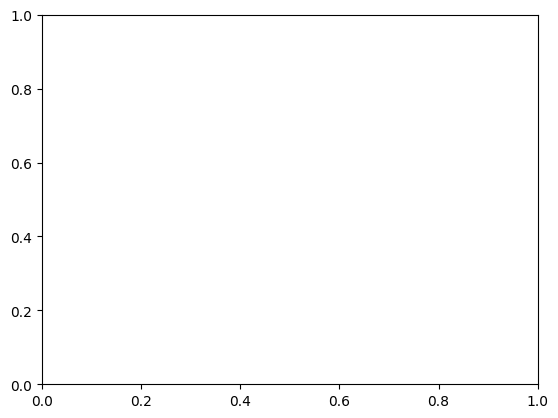

In [208]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
epochs = 500  # Number of epochs to train
criterion = nn.MSELoss(reduction='mean')  # Mean Squared Error Loss
optimizer = optim.AdamW(model.parameters(), lr=0.001)
train_loss = []
test_loss = []
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0 
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        #model.train_enforce_constraints()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_dataloader)
    train_loss.append(avg_loss)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_dataloader):
            model.eval()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
        avg_loss_test = running_loss / len(test_dataloader)
    test_loss.append(avg_loss_test)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Testloss: {avg_loss_test:.4f}")
plt.plot(test_loss, title = 'test_loss')
plt.legend()
plt.show()
plt.plot(train_loss, titel = 'train_loss')
plt.legend()
plt.show()


print("Training Complete!")